<a href="https://colab.research.google.com/github/HMercer/BacktestingForDad/blob/main/MA_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HOW TO USE ** 
1. Choose the variables you want 
2. In the toolbar above, click 'Runtime' then 'Run all'







In [1]:
#@title 

# !pip3 install fastquant
# !pip install backtesting
# !pip install pandas
# !pip install --user pandas==0.22

In [2]:
#@title 
from fastquant import get_stock_data, backtest
#Importing backtesting library
# from backtesting import Backtest, Strategy
# from backtesting.lib import crossover
# from backtesting.test import SMA, GOOG

#Importing stock data 
from pandas_datareader import data
import pandas as pd

import numpy as np

import matplotlib.colors as mcolors
import matplotlib.pyplot as pl
pl.style.use("default")

from datetime import date



In [3]:
#@title Pick variable values for the model

#@markdown Choose the stock you want to model by typing it's symbol:
symbol='DSNY' #@param {type:"string"}

start_date = '2018-01-01' #@param {type:"date"}
#@markdown The end date is today

end_date = date.today()

#@markdown Set the amount of money you want to invest on the start date:
init_cash=100 #@param {type:"number"}

commision = 0.002 


#@markdown The output of running this cell is the data imported for your stock. This is just so you can visually check it is the right stock.

imported_stock_data = data.DataReader(symbol, 'yahoo', start_date, end_date)

dcv_data = imported_stock_data[["Close"]]
dcv_data_full = imported_stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]
dcv_data.head(-10)

,Close
Date,
2018-01-02,1.010
2018-01-03,0.975
2018-01-04,0.925
2018-01-05,0.925
2018-01-08,0.900
2018-01-09,0.900
2018-01-10,0.975
2018-01-11,0.975
2018-01-12,1.020


In [4]:
#@title 
fast_periods = np.arange(1,20,1, dtype=int)
slow_periods = np.arange(20,241,5, dtype=int)

# make a grid of 0's (placeholder)
period_grid = np.zeros(shape=(len(fast_periods),len(slow_periods)))


(19, 45)

In [5]:
#@title This cell will take around 2 minutes to run as this is the model

for i,fast_period in enumerate(fast_periods): 
    for j,slow_period in enumerate(slow_periods):
        results = backtest('smac', 
                           dcv_data, 
                           fast_period=fast_period,
                           slow_period=slow_period,
                           init_cash=init_cash,
                           verbose=False, 
                           plot=False
                          )
        net_profit = results.final_value.values[0]-init_cash
        period_grid[i,j] = net_profit


In [6]:
#@title This is the total profit you'd make form the start date to now if you used the optimised model caluclated above. 
net_profit

81.52439221188425

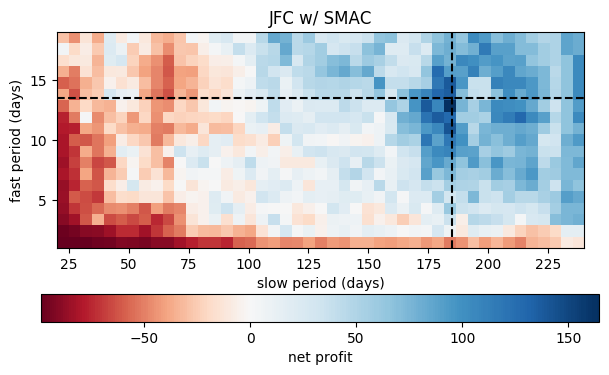

In [8]:
#@title This plot is a heatmap of all the tested short and long days and how much profit would be made using those day choices. You can see the brightest blue is the profit and the red (if any) if the loss. The intersecting hashed lines indicate the optimum short/long window choices. 
import matplotlib.colors as mcolors
import matplotlib.pyplot as pl
pl.style.use("default")

fig, ax = pl.subplots(1,1, figsize=(8,4))
xmin, xmax = slow_periods[0],slow_periods[-1]
ymin, ymax = fast_periods[0],fast_periods[-1]

#make a diverging color map such that profit<0 is red and blue otherwise
cmap = pl.get_cmap('RdBu')
norm = mcolors.DivergingNorm(vmin=np.where(period_grid.min()<0, period_grid.min(), -1), 
                             vmax = period_grid.max(), 
                             vcenter=0
                            )
#plot matrix
cbar = ax.imshow(period_grid, 
                 origin='lower', 
                 interpolation='none', 
                 extent=[xmin, xmax, ymin, ymax], 
                 cmap=cmap,
                 norm=norm
                )
pl.colorbar(cbar, ax=ax, shrink=0.9,
            label='net profit', orientation="horizontal")

# search position with highest net profit
y, x = np.unravel_index(np.argmax(period_grid), period_grid.shape)
best_slow_period = slow_periods[x]
best_fast_period = fast_periods[y]
# mark position
# ax.annotate(f"max profit={period_grid[y, x]:.0f}@({best_slow_period}, {best_fast_period}) days", 
#             (best_slow_period+5,best_fast_period+1)
#            )
ax.axvline(best_slow_period, 0, 1, c='k', ls='--')
ax.axhline(best_fast_period+0.5, 0, 1, c='k', ls='--')

# add labels
ax.set_aspect(5)
pl.setp(ax,
        xlim=(xmin,xmax),
        ylim=(ymin,ymax),
        xlabel='slow period (days)',
        ylabel='fast period (days)',
        title='JFC w/ SMAC',
       );

In [9]:
#@title This tells you the optimal short and long window.
print(f"max profit={period_grid[y, x]:.0f} @ ({best_slow_period},{best_fast_period}) days")

max profit=165 @ (185,13) days


In [10]:
#@title Percentage of iterations that resulted in a profit
percent_positive_profit=(period_grid>0).sum()/np.product(period_grid.shape)*100
percent_positive_profit

62.3391812865497

In [11]:
#@title Percentage of iterations that resulted in breaking even
percent_breakeven=(period_grid==0).sum()/np.product(period_grid.shape)*100
percent_breakeven

0.0

In [12]:
#@title Percentage of iterations that resulted in a loss
percent_loss=(period_grid<0).sum()/np.product(period_grid.shape)*100
percent_loss

37.6608187134503

Starting Portfolio Value: 100.00
2021-02-05, ===Global level arguments===
2021-02-05, init_cash : 100
2021-02-05, buy_prop : 1
2021-02-05, sell_prop : 1
2021-02-05, commission : 0.0075
2021-02-05, stop_loss : 0
2021-02-05, stop_trail : 0
===Strategy level arguments===
fast_period : 13
slow_period : 185
2021-02-05, Final Portfolio Value: 264.7187692001462
2021-02-05, Final PnL: 164.72
Time used (seconds): 0.2436995506286621
Number of strat runs: 1
Number of strats per run: 1
Strat names: ['smac']
**************************************************
--------------------------------------------------
Strategy Parameters	init_cash:100	buy_prop:1	sell_prop:1	commission:0.0075	stop_loss:0	stop_trail:0	execution_type:close	channel:	symbol:	allow_short:False	short_max:1.5	add_cash_amount:0	add_cash_freq:M	fast_period:13	slow_period:185
Returns	rtot:0.9734978281740903	ravg:0.001248074138684731	rnorm:0.3695944620927788	rnorm100:36.95944620927788
Sharpe	sharperatio:0.8724529367047789
Drawdown	len:0

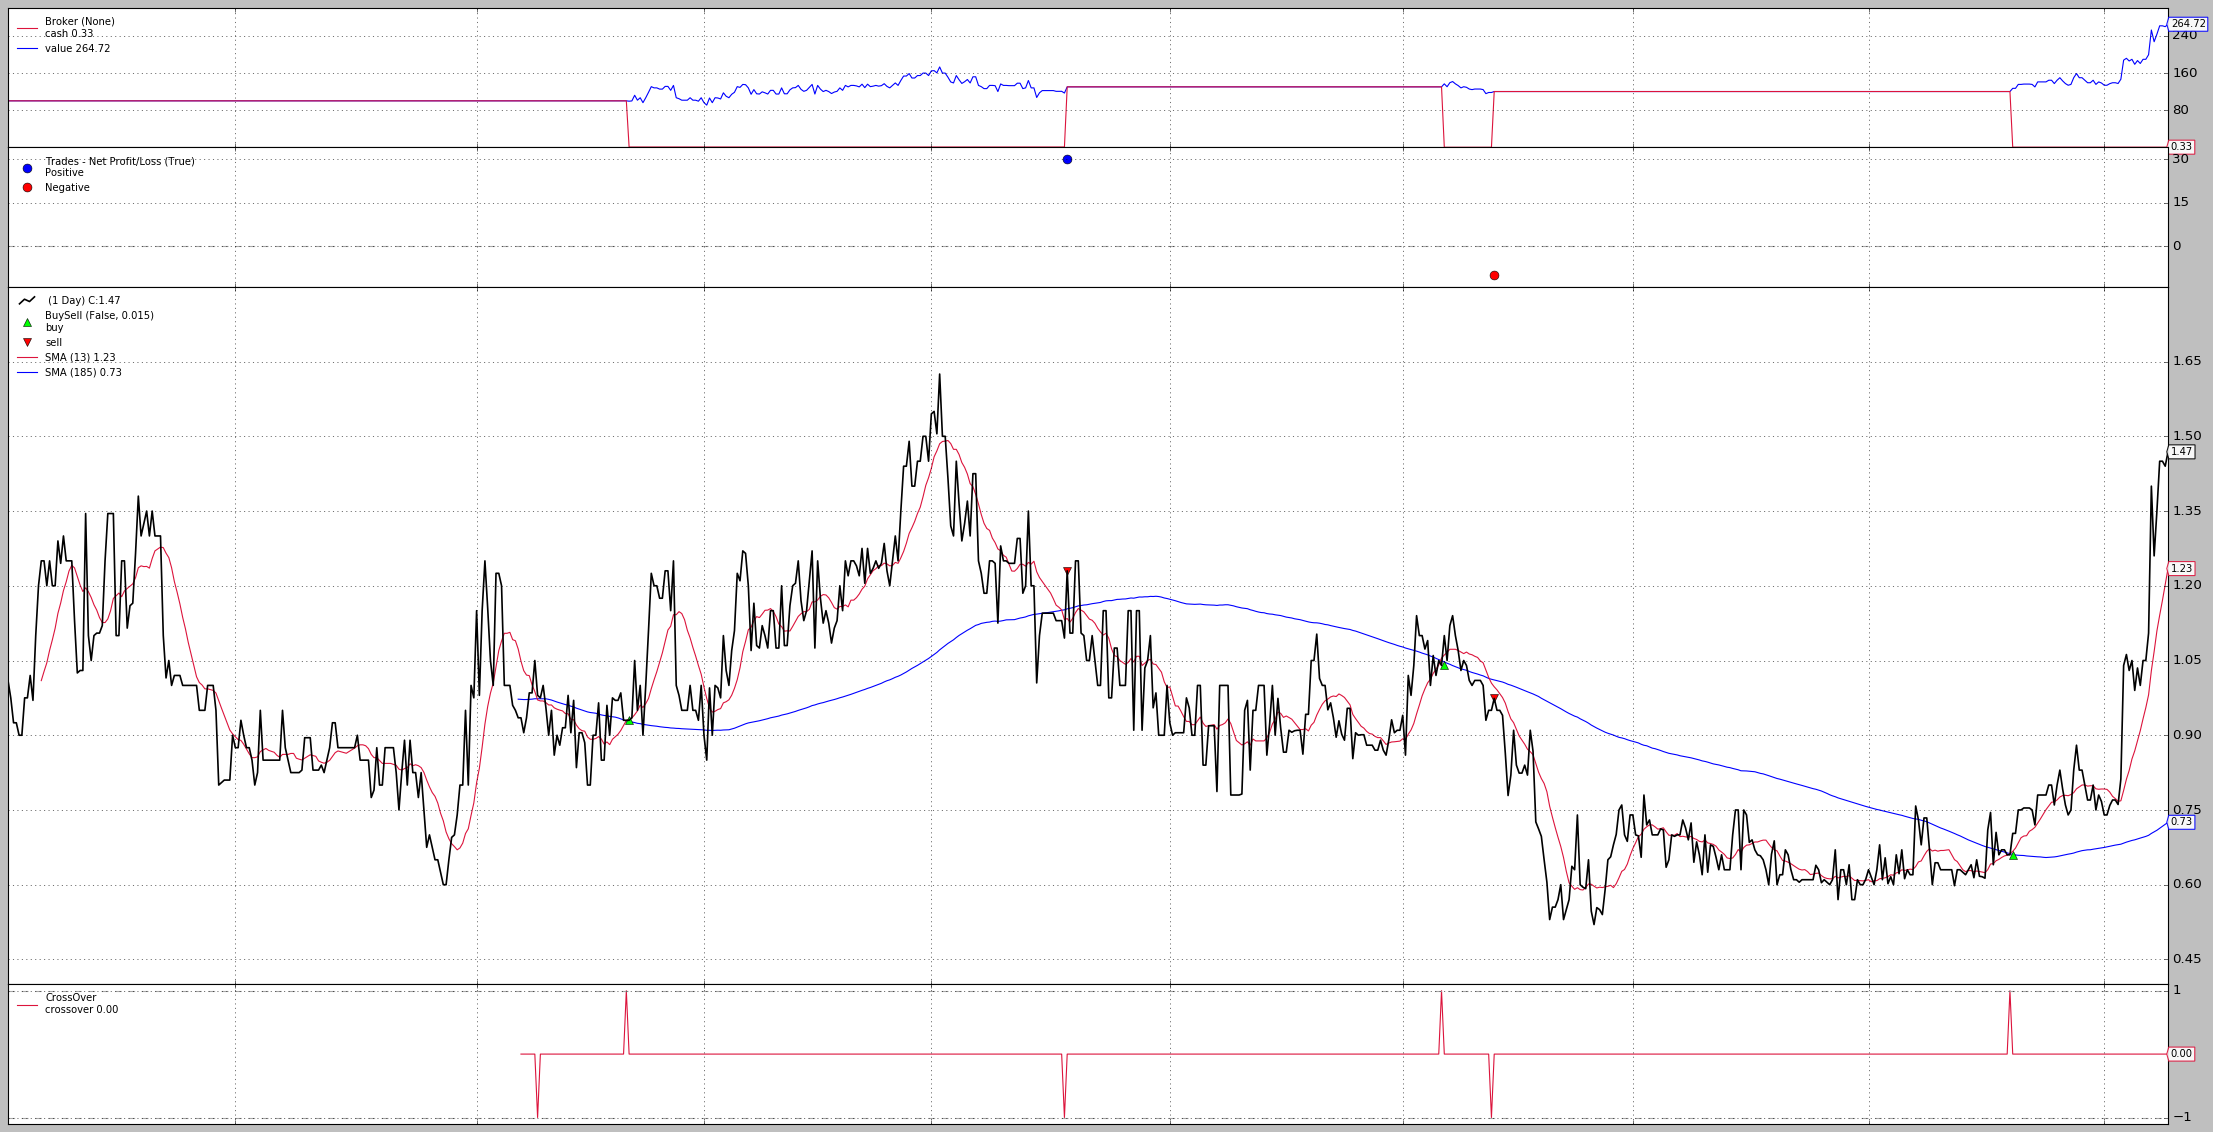

164.7187692001462

In [13]:
#@title Plot Model for the optium parameters. 

results = backtest('smac', 
                   dcv_data, 
                   fast_period=best_fast_period, 
                   slow_period=best_slow_period, 
                   verbose=True,
                   plot=True, 
                   init_cash=init_cash)
net_profit = results.final_value.values[0]-init_cash
net_profit

In [14]:
#@title 

#Importing backtesting library
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

#Importing stock data 
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
#@title 
class SmaCross(Strategy):
    n1 = best_fast_period
    n2 = best_slow_period

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()




In [16]:
#@title The plot and table shows the intricate details of buying and selling based on the OPTIMUM short and long window. 
bt = Backtest(dcv_data_full, SmaCross,
              cash=init_cash, commission=commision,
              exclusive_orders=True)

output = bt.run()
bt.plot()


In [17]:
#@title This gives you more detail about the strategy with optimum parameters. The Equity final may differ from the profit defined earlier as they are slightly different models but overall they will have the same trend.
output

Start                     2018-01-02 00:00:00
End                       2021-02-05 00:00:00
Duration                    97632000000000000
Exposure Time [%]                     75.3846
Equity Final [$]                      357.005
Equity Peak [$]                       357.005
Return [%]                            257.005
Buy & Hold Return [%]                 45.4257
Return (Ann.) [%]                     50.8538
Volatility (Ann.) [%]                 130.148
Sharpe Ratio                         0.390738
Sortino Ratio                          1.0894
Calmar Ratio                          1.33303
Max. Drawdown [%]                    -38.1491
Avg. Drawdown [%]                     -10.071
Max. Drawdown Duration      27475200000000000
Avg. Drawdown Duration       2678400000000000
# Trades                                    6
Win Rate [%]                          83.3333
Best Trade [%]                        112.497
Worst Trade [%]                      -7.42325
Avg. Trade [%]                    

In [18]:
#@title 

# Initialize the short and long windows
short_window = best_fast_period
long_window = best_slow_period

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=dcv_data_full.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = dcv_data_full['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = dcv_data_full['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()


,signal,short_mavg,long_mavg,positions
2018-01-02,0.0,1.010000,1.010000,NaN
2018-01-03,0.0,0.992500,0.992500,0.0
2018-01-04,0.0,0.970000,0.970000,0.0
2018-01-05,0.0,0.958750,0.958750,0.0
2018-01-08,0.0,0.947000,0.947000,0.0
2018-01-09,0.0,0.939167,0.939167,0.0


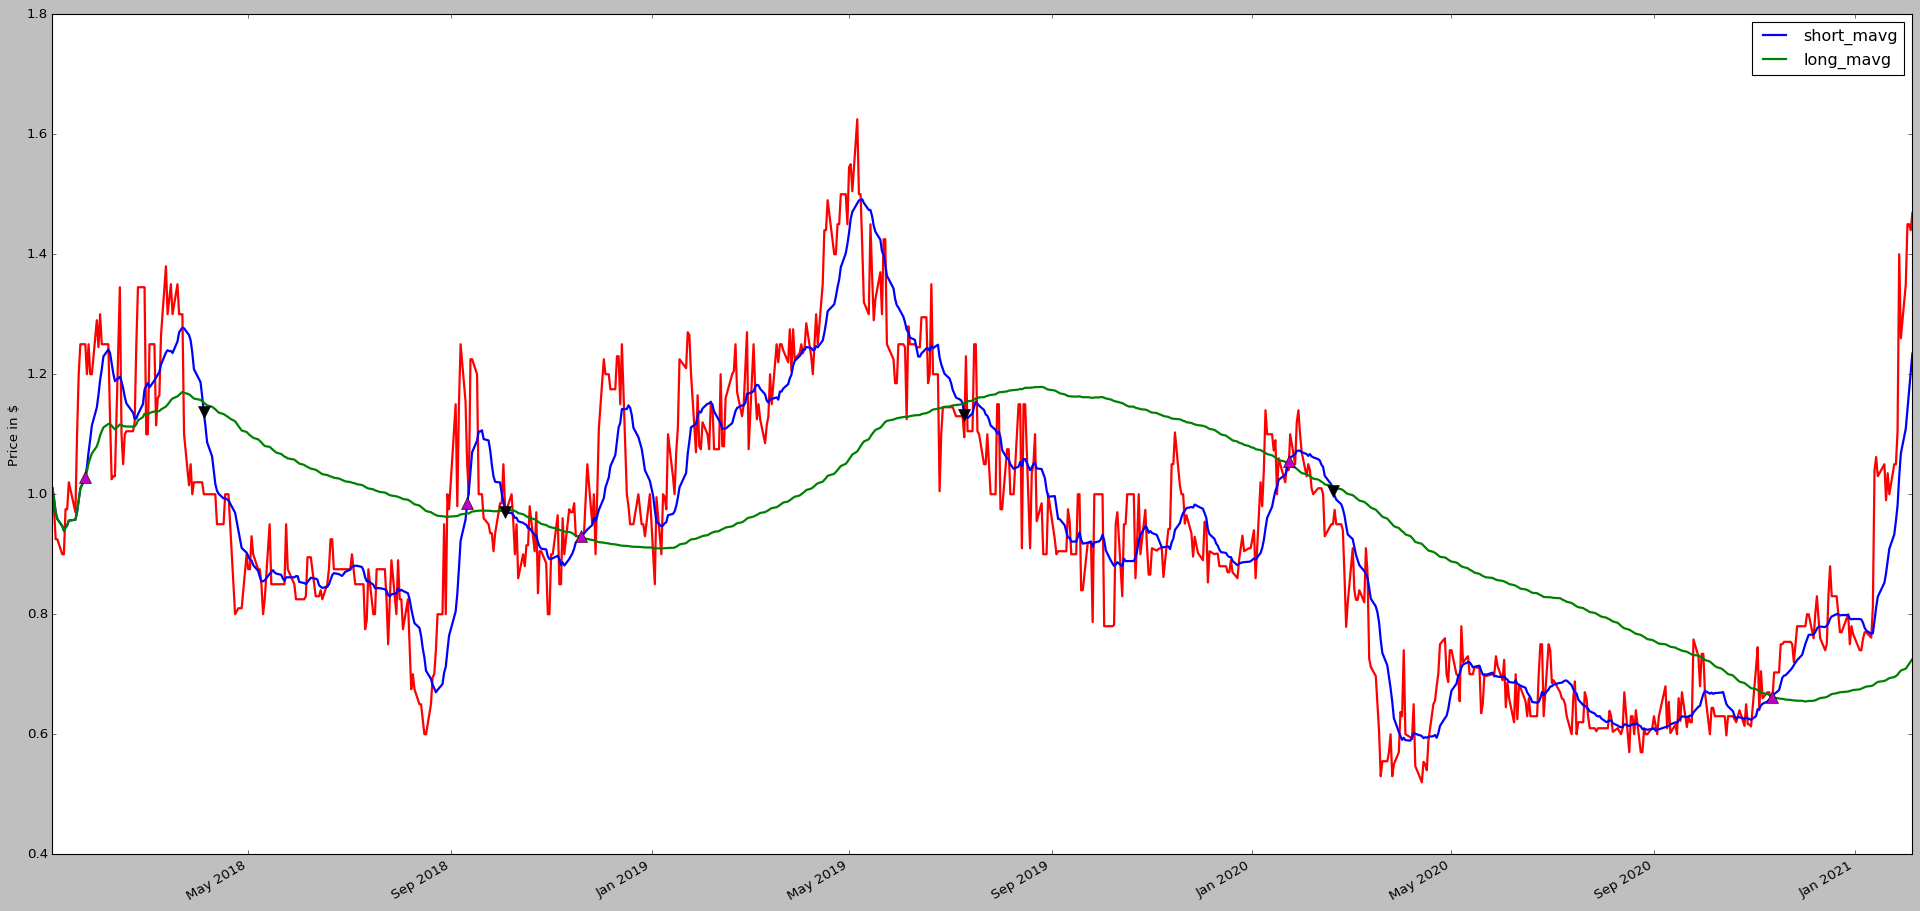

In [19]:
#@title This plot shows the buy and sell times based on the OPTIMUM model. As you can see, up=arrows indicate buy and down-arrows indicate selling.

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
dcv_data_full['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [22]:
#@title This final cell tells you the action to take based on the model and todays data. If;
#@markdown - 0 then hold/don't buy
#@markdown - -1 then sell
#@markdown - 1 then buy

signals.tail(1)['positions']

2021-02-05    0.0
Name: positions, dtype: float64